In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing 
import matplotlib.pyplot as plt
from pandas import datetime
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

<ipython-input-14-500d58bfe76b>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Dataset Loading

In [2]:
def function_transpose(file):
    data=pd.read_csv(file)
    data=data.T
    return data
    
file = 'weather_daily_darksky.csv'
function_transpose(file)

temperatureMax,Year,11.96,8.59,10.33,8.07,8.22,7.97,13.19,8.32,9.82,...,10.67,5.94,10.04,10.2,12.43,9.03,10.31,18.97,8.83,9.9
0,temperatureMax,11.96,8.59,10.33,8.07,8.22,7.97,13.19,8.32,9.82,...,10.67,5.94,10.04,10.2,12.43,9.03,10.31,18.97,8.83,9.9
1,temperatureMaxTime,2011-11-11 23:00:00,2011-12-11 14:00:00,2011-12-27 02:00:00,2011-12-02 23:00:00,2011-12-24 23:00:00,2011-12-15 14:00:00,2011-11-19 14:00:00,2011-11-16 23:00:00,2011-12-12 23:00:00,...,2014-02-17 14:00:00,2014-01-30 15:00:00,2014-03-27 13:00:00,2014-03-24 13:00:00,2014-03-28 14:00:00,2014-01-26 16:00:00,2014-02-27 14:00:00,2014-03-09 14:00:00,2014-02-12 16:00:00,2014-02-15 12:00:00
2,windBearing,123,198,225,232,252,234,117,117,221,...,175,65,75,155,87,233,224,172,210,233
3,icon,fog,partly-cloudy-day,partly-cloudy-day,wind,partly-cloudy-night,wind,fog,fog,wind,...,partly-cloudy-day,partly-cloudy-day,fog,partly-cloudy-day,fog,partly-cloudy-day,partly-cloudy-day,partly-cloudy-night,wind,wind
4,dewPoint,9.4,4.49,5.47,3.69,2.79,2.41,8.12,5.58,4.1,...,5.02,3.08,2.08,0.16,3.67,2.39,3.08,4.3,1.94,2.95
5,temperatureMinTime,2011-11-11 07:00:00,2011-12-11 01:00:00,2011-12-27 23:00:00,2011-12-02 07:00:00,2011-12-24 07:00:00,2011-12-15 00:00:00,2011-11-19 23:00:00,2011-11-16 07:00:00,2011-12-12 07:00:00,...,2014-02-17 05:00:00,2014-01-30 23:00:00,2014-03-27 05:00:00,2014-03-24 06:00:00,2014-03-28 03:00:00,2014-01-26 21:00:00,2014-02-27 23:00:00,2014-03-09 07:00:00,2014-02-12 01:00:00,2014-02-15 23:00:00
6,cloudCover,0.79,0.56,0.85,0.32,0.37,0.42,0.26,0.81,0.38,...,0.56,0.81,0.44,0.37,0.19,0.4,0.32,0.04,0.59,0.35
7,windSpeed,3.88,3.94,3.54,3,4.46,4.71,2.37,2.36,5.02,...,4.07,1.52,2.36,2.69,3.31,4.55,4.14,2.78,7.24,9.96
8,pressure,1016.08,1007.71,1032.76,1012.12,1028.17,996.75,1016.8,1017.4,1002.47,...,1007.8,1001.76,1012.88,1012.71,1014.82,1002.1,1007.02,1022.44,994.27,988.63
9,apparentTemperatureMinTime,2011-11-11 07:00:00,2011-12-11 02:00:00,2011-12-27 22:00:00,2011-12-02 07:00:00,2011-12-24 07:00:00,2011-12-15 00:00:00,2011-11-19 08:00:00,2011-11-16 04:00:00,2011-12-12 08:00:00,...,2014-02-17 05:00:00,2014-01-30 05:00:00,2014-03-27 06:00:00,2014-03-24 06:00:00,2014-03-28 03:00:00,2014-01-26 22:00:00,2014-02-27 22:00:00,2014-03-09 07:00:00,2014-02-12 01:00:00,2014-02-15 23:00:00


In [7]:
weather = pd.read_csv('weather_daily_darksky.csv')
energy = pd.read_csv('energy.csv')

# Dataset Preprocessing

In [8]:
"""
The number of homes for which energy data was obtained on different days is vary throughout the dataset.
This might lead to the incorrect conclusion that the energy for a certain day is high when the data was
only obtained for a larger number of residences. Each day's house count will be examined.
"""

housecount = energy.groupby('day')[['LCLid']].nunique()

# Data Normalization

In [9]:
"""
Because data collection across homes is uneven, we'll use energy per household as our prediction objective rather than energy alone. 
This is an optional step because we can also anticipate the total amount of energy used by each home. However, there are a lot of 
unique homes for which we'll have to repeat the procedure, and our ultimate objective is to anticipate aggregate consumption, not household consumption.
"""

energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()
energy.count()


day           829
energy_sum    829
LCLid         829
dtype: int64

In [10]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [11]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

# Relationship of weather condition with electricity consumption

In [12]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97


Correlation between Weather Variables and Energy Consumption
 - Energy has high positive correlation with humidity and high negative correlation with temperature.
 - Dew Point, UV Index display multicollinearity with Temperature, hence discarded
 - Cloud Cover and Visibility display multicollinearity with Humidity, hence discarded
 - Pressure and Moon Phase have minimal correlation with Energy, hence discarded
 - Wind Speed has low correlation with energy but does not show multicollinearity

# Clustering

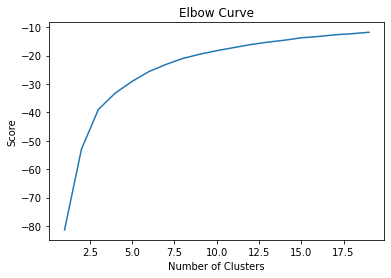

In [16]:
"""
There are a lot of variables in meteorological data, and not all of them are relevant.
We'll try to make weather clusters to see if we can come up with a day's weather based 
on granular weather data like temperature and precipitation.
"""

#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

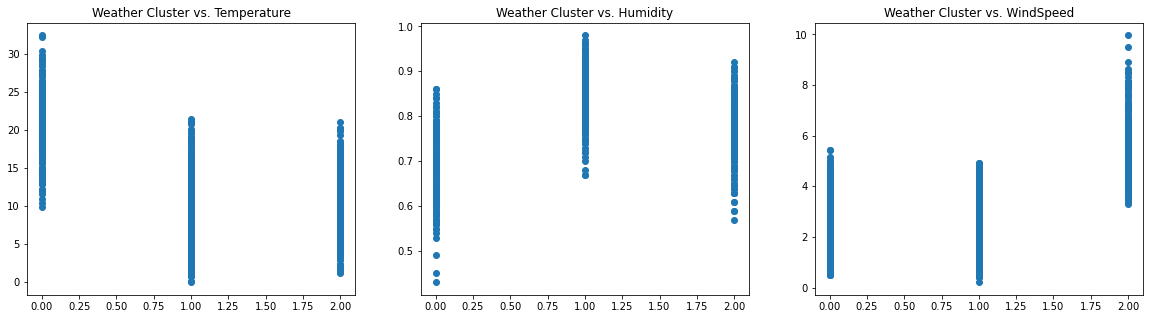

In [18]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()
# put this in a loop

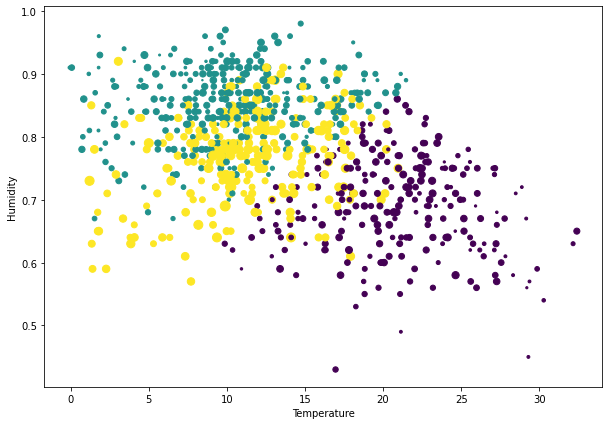

In [19]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax, 
            weather_energy.humidity, 
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

In [21]:
holiday = pd.read_csv('holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

# Fitting

In [22]:
model_data = weather_energy[['avg_energy','weather_cluster','holiday_ind']]
# train = model_data.iloc[0:round(len(model_data)*0.90)]
# test = model_data.iloc[len(train)-1:]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

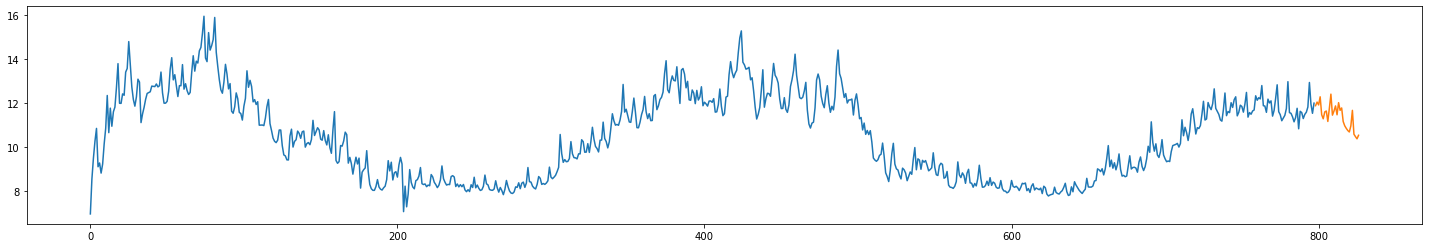

In [23]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))

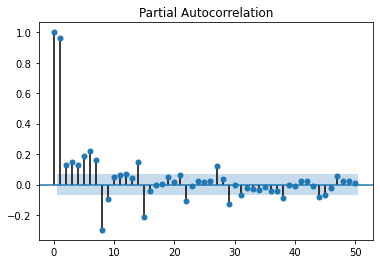

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(train.avg_energy,lags=50)
plt.show()

Autocorrelation plot shows gradual decay while Partial AutoCorrelation shows that there is a sharp drop after 1st lag. This means that most of the higher-order autocorrelations are effectively explained by the k = 1 lag. Therefore, the series displays AR 'signature'

# Prediction

In [29]:
import statsmodels.api as sm

endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster','holiday_ind']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          avg_energy   No. Observations:                  798
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 12)   Log Likelihood                -649.414
Date:                             Mon, 16 May 2022   AIC                           1326.828
Time:                                     00:24:22   BIC                           1392.148
Sample:                                          0   HQIC                          1351.943
                                             - 798                                         
Covariance Type:                               opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.0065      0.017     -0.382      0.703      -0.040       0.027
const           -2.999e-08   2.73e-10   -110.007      0.000   -3.05e-08   -2.95e-08
weather_cluster    -0.0039      0.025     -0.156      0.876      -0.053       0.045
holiday_ind        -0.0348      0.088     -0.395      0.693      -0.207       0.138
ar.L1              -0.0019      0.087     -0.022      0.983      -0.172       0.168
ar.L2              -0.1547      0.032     -4.853      0.000      -0.217      -0.092
ar.L3              -0.1434      0.039     -3.711      0.000      -0.219      -0.068
ar.L4              -0.1512      0.038     -3.982      0.000      -0.226      -0.077
ar.L5              -0.1635      0.040     -4.097      0.000      -0.242      -0.085
ar.L6               0.0083      0.037      0.226      0.821      -0.063       0.080
ar.L7               0.3528      0.028     12.407      0.000       0.297       0.409
ma.L1              -0.1840      0.092     -2.007      0.045      -0.364      -0.004
ar.S.L12           -0.4832      0.033    -14.843      0.000      -0.547      -0.419
sigma2              0.3041      0.013     24.075      0.000       0.279       0.329
===================================================================================
Ljung-Box (Q):                      221.13   Jarque-Bera (JB):                45.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+17. Standard errors may be unstable.
"""

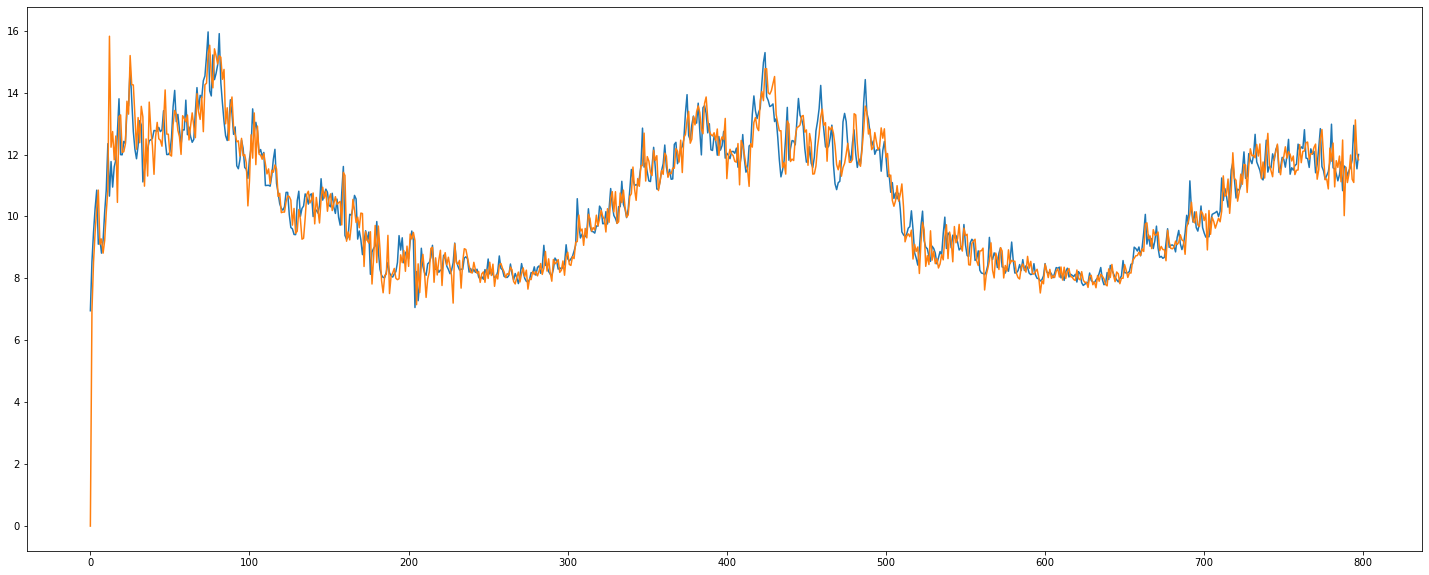

In [32]:
#Model fit

train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [40]:
# prediction

predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,
                            exog = sm.add_constant(test[['weather_cluster','holiday_ind']]))
test['predicted'] = predict.values
test.tail(5)

<ipython-input-40-ed90cde52d8b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = predict.values


,avg_energy,weather_cluster,holiday_ind,predicted
822,11.673756,2,0,11.553517
823,10.586235,2,0,10.703869
824,10.476498,2,0,11.440806
825,10.375366,2,0,11.867154
826,10.537250,2,0,11.479704


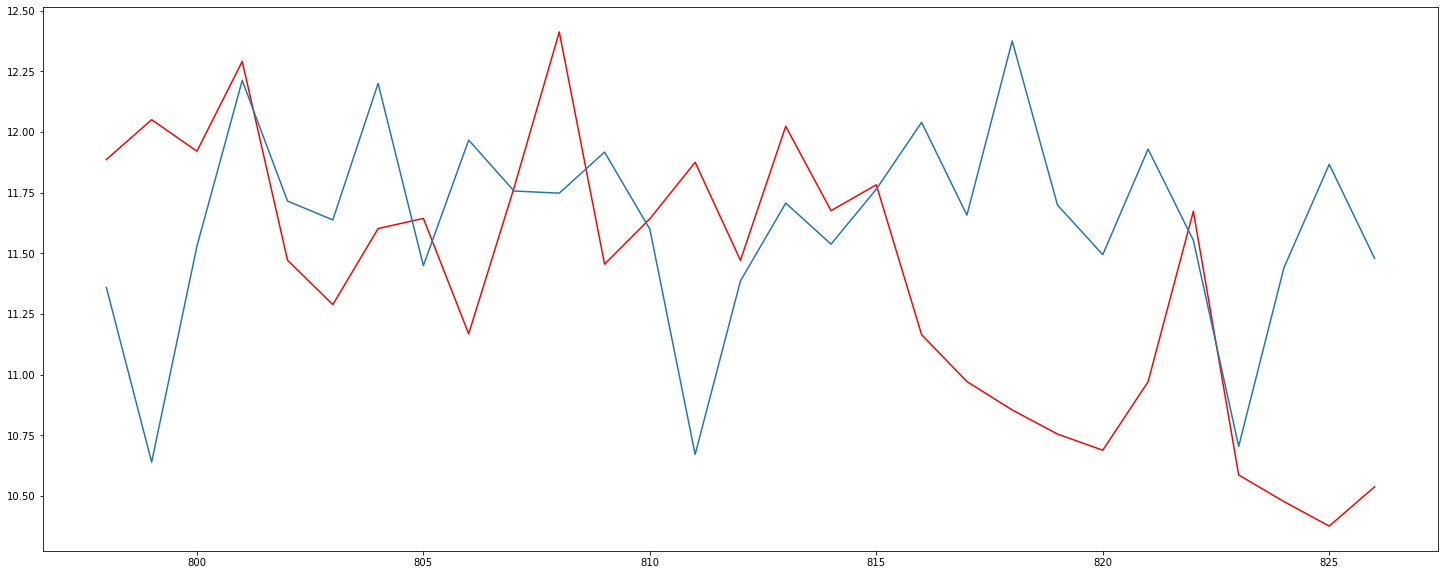

In [43]:
plt.figure(figsize=(6,6))
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()